<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with tensorflow part 1 : Feature Extraction

In [1]:
!pip install tensorflow==2.7.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 23 kB/s 
     |████████████████████████████████| 463 kB 35.8 MB/s 
     |████████████████████████████████| 1.3 MB 56.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [2]:
!nvidia-smi

Thu Aug 18 14:10:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [3]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-08-18 14:10:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   151MB/s    in 1.1s    

2022-08-18 14:10:21 (151 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os 

for dirpath, dirnames , filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 10 directori

## Creating Data loaded ( preparing the data)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training_images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print("Testing Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size =  BATCH_SIZE,
                                             class_mode = 'categorical')


Training_images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks ( things to run while our model trains)

In [6]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f" saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [7]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from  tensorflow.keras import layers

In [9]:
def create_model ( model_url, num_classes = 10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable= False,
                                           name= "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation = "softmax", name= "output_layer")
  ])

  return model


## Creating and testing ResNet tensorflow hub feature extraction model 

In [10]:
resnet_model = create_model(resnet_url, 
                            num_classes = train_data_10_percent.num_classes)

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(loss= 'categorical_crossentropy',
                     optimizer  = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

 saving TensorBoard log files to : tensorflow_hub/resnet50V2/20220818-141034
Epoch 1/5
24/24 [==============================] - 32s 784ms/step - loss: 1.8941 - accuracy: 0.3560 - val_loss: 1.2453 - val_accuracy: 0.5900
Epoch 2/5
24/24 [==============================] - 16s 682ms/step - loss: 0.8969 - accuracy: 0.7360 - val_loss: 0.8776 - val_accuracy: 0.7148
Epoch 3/5
24/24 [==============================] - 16s 675ms/step - loss: 0.6067 - accuracy: 0.8240 - val_loss: 0.7568 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 16s 678ms/step - loss: 0.4591 - accuracy: 0.8907 - val_loss: 0.7162 - val_accuracy: 0.7676
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.3749 - accuracy: 0.9160 - val_loss: 0.6804 - val_accuracy: 0.7776


In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss , label = "training_loss")
  plt.plot(epochs,val_loss, label = "val_loss")
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy, label= 'training_accuracy')
  plt.plot(epochs,val_accuracy, label = 'val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

##Creating and testing EfficientNetBO tensorflow hub feature extraction model

In [15]:
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes)

In [16]:
efficientnet_model.compile(loss = 'categorical_crossentropy',
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics = ['accuracy'])

In [18]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

 saving TensorBoard log files to : tensorflow_hub/efficientnetB0/20220818-141451
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.8426 - accuracy: 0.4493 - val_loss: 1.2864 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 15s 649ms/step - loss: 1.0436 - accuracy: 0.7840 - val_loss: 0.8642 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 16s 698ms/step - loss: 0.7467 - accuracy: 0.8507 - val_loss: 0.6952 - val_accuracy: 0.8464
Epoch 4/5
24/24 [==============================] - 15s 660ms/step - loss: 0.5995 - accuracy: 0.8787 - val_loss: 0.6100 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 15s 647ms/step - loss: 0.5073 - accuracy: 0.8933 - val_loss: 0.5567 - val_accuracy: 0.8616


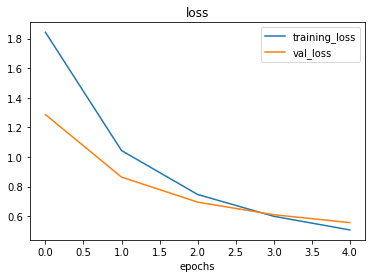

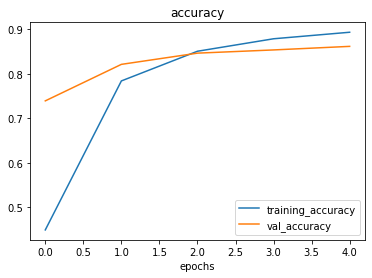

In [20]:
plot_loss_curves(efficientnet_history)

## compare the result  of our models using TensorBoard

In [21]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "efficientnetB0 vs resnet50V2" \
--description "comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=2NFcXGIuQuM5EadbTtMYVsbnxEbVRw&prompt=consent&access_type=off

In [22]:
!tensorboard dev list

https://tensorboard.dev/experiment/KIanzApPS8eaD9Z64mlFqA/
	Name                 efficientnetB0 vs resnet50V2
	Description          comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   KIanzApPS8eaD9Z64mlFqA
	Created              2022-08-18 14:48:48 (16 minutes ago)
	Updated              2022-08-18 14:48:53 (15 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5795363
Total: 1 experiment(s)


In [23]:
!tensorboard dev delete --experiment_id  KIanzApPS8eaD9Z64mlFqA

Deleted experiment KIanzApPS8eaD9Z64mlFqA.


In [24]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
